In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [41]:

data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(5))

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01/2008               0.0        26.239        213.791  
03/01/2008               0.0        24.000        175.000  
04/01/2008               0.0        11.000        164.000  
05/01/2008               0.0        24.000        177.000  


In [42]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [43]:
# def create_sequences(data, seq_length):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         sequences.append(data[i:i + seq_length])
#         targets.append(data[i + seq_length, 0])  
#     return np.array(sequences), np.array(targets)

In [44]:
sequence_length = 1 # Sử dụng 30 ngày để dự đoán
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

In [45]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(X_train)

[[[0.08651911 0.04639671 0.09251301 ... 0.         0.1056379  0.16986817]]

 [[0.08350101 0.04373844 0.18493939 ... 0.         0.1065453  0.40261959]]

 [[0.1056338  0.03926346 0.21933761 ... 0.         0.10587011 0.32956685]]

 ...

 [[0.5583501  0.50399467 0.8627451  ... 0.59950327 0.27341437 0.04531638]]

 [[0.62575453 0.49448355 0.86631016 ... 0.59065303 0.35991065 0.30062147]]

 [[0.68913481 0.36608332 0.84135472 ... 0.56628396 0.53145965 0.47092279]]]


In [46]:
model = Sequential()

# Lớp đầu vào
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Lớp Dropout để tránh overfitting
model.add(Dropout(0.2))

# Lớp đầu ra
model.add(Dense(7))

In [47]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18432     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 18887 (73.78 KB)
Trainable params: 18887 (73.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 3s 11ms/step - loss: 0.0397 - val_loss: 0.0165
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0139
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0122
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0104
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 8/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 10/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 11/50
64/64 

In [49]:
# Hàm tính Nash-Sutcliffe Efficiency (NSE)
def nse(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - numerator / denominator

In [50]:
# Dự đoán
y_pred = model.predict(X_test)

# Chuyển đổi kích thước y_pred để phù hợp với y_test
y_pred = y_pred.reshape(y_pred.shape[0], -1)  # Biến đổi thành mảng 2 chiều


# Giảm số lượng mẫu của y_pred và y_test xuống còn 512 mẫu
y_pred_reduced = y_pred[:512]  # Cắt y_pred để chỉ lấy 512 mẫu đầu tiên
y_test_reduced = y_test[:512]  # Cắt y_test để chỉ lấy 512 mẫu đầu tiên
# Tính toán các chỉ số
r2 = r2_score(y_test_reduced, y_pred_reduced)
print("R² (R-squared):", r2)

mae = mean_absolute_error(y_test_reduced, y_pred_reduced)
print("MAE (Mean Absolute Error):", mae)

rmse = np.sqrt(mean_squared_error(y_test_reduced, y_pred_reduced))
print("RMSE (Root Mean Square Error):", rmse)

nse = nse(y_test_reduced, y_pred_reduced)
print("NSE (Nash-Sutcliffe Efficiency):", nse)


16/16 [==============================] - 0s 2ms/step
R² (R-squared): 0.7892766907068495
MAE (Mean Absolute Error): 0.04334952608523709
RMSE (Root Mean Square Error): 0.07520722855661345
NSE (Nash-Sutcliffe Efficiency): 0.863991848281303


In [51]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
print(new_data)

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
2015-01-01         85        575.000         757.694             120.0   
2015-01-02        114        840.327        1045.743             116.0   
2015-01-03        141       1059.445         976.320             115.0   
2015-01-04        147        576.221         671.221             115.0   
2015-01-05        135        875.634         946.884             116.0   
...               ...            ...             ...               ...   
2017-01-03        160        280.500         720.369              82.0   
2017-01-04        120        270.500         600.369              79.0   
2017-01-05        140        260.500         740.369              76.0   
2017-01-06        200        230.500         701.369              90.0   
2017-01-07        210        240.500         760.369              74.0   

            chayMayTuyenQuan  nuocVeT

In [52]:
data_test_scaled = scaler.transform(new_data)
# Chia dữ liệu mới thành chuỗi thời gian
# Tạo các mẫu test từ dữ liệu test
# Chia dữ liệu mới thành chuỗi thời gian
X_new,Y_new = [],[]
for i in range(sequence_length, len(data_test_scaled)):
    X_new.append(data_test_scaled[i-sequence_length:i])
    Y_new.append(data_test_scaled[i])
X_new = np.array(X_new)
print(len(X_new))
y_new = np.array(Y_new)

737


In [53]:
predictions = model.predict(X_new)
predictions_new_original = scaler.inverse_transform(predictions)[:,0]
y_test_new_original = scaler.inverse_transform(y_new)[:,0]
predictions_new_original = np.round(predictions_new_original, 3)

24/24 [==============================] - 0s 2ms/step


In [54]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = new_data.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]
# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})
# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-02        114.0  109.232002
2015-01-03        141.0  136.279999
2015-01-04        147.0  153.871002
2015-01-05        135.0  147.636002
2015-01-06        127.0  145.936996
...                 ...         ...
2017-01-03        160.0  144.548996
2017-01-04        120.0  151.671005
2017-01-05        140.0  126.294998
2017-01-06        200.0  138.479996
2017-01-07        210.0  175.981995

[737 rows x 2 columns]


737
DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31',
               '2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06'],
              dtype='datetime64[ns]', name='Ngay', length=737, freq=None)


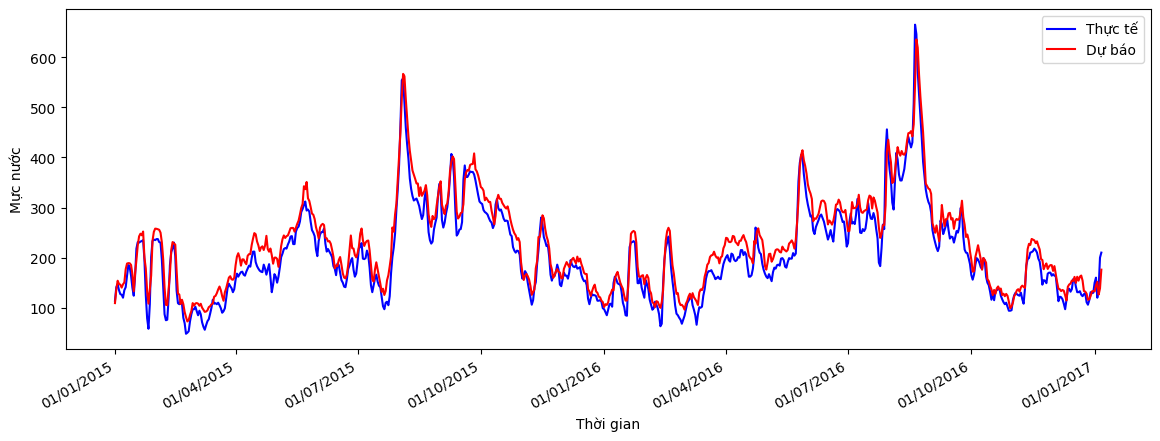

In [55]:
import matplotlib.dates as mdates

min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))
print(min_length)
# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]

y_test_new_original = y_test_new_original[:min_length]
print(dates)
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()